# Project 3: Movie Recommendations

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing Data

Setting up variables for that hold the paths to the various data files. The data files don't have a header row, so explicitly defining the column names based on the README file that came with the data.

In [18]:
PARENT_DIR = "data/ml-1m/"
ratings_path = PARENT_DIR + "ratings.dat"
movies_path = PARENT_DIR + "movies.dat"
users_path = PARENT_DIR + "users.dat"

ratings_col_names = ["UserID", "MovieID", "Rating", "Timestamp"]
movies_col_names = ["MovieID", "Title", "Genres"]
users_col_names = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]

Import the data using pandas into separate data frames.

In [19]:
# setting engine to python to avoid a warning when using regex delimiter
# change encoding to fix error that was occurring due to certain characters in movie titles not having utf-8 encoding such as
# the letter é
ratings_df = pd.read_csv(ratings_path, sep="::", engine='python', names=ratings_col_names)
movies_df = pd.read_csv(movies_path, sep="::", engine='python', encoding='ISO-8859-1', names=movies_col_names)
users_df = pd.read_csv(users_path, sep="::", engine='python', names=users_col_names)

Do a quick santiy check to see if the data was loaded correctly

In [20]:
print("Shape: ", ratings_df.shape)
ratings_df.head()

Shape:  (1000209, 4)


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [21]:
print("Shape: ", movies_df.shape)
movies_df.head()

Shape:  (3883, 3)


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [22]:
print("Shape: ", users_df.shape)
users_df.head()

Shape:  (6040, 5)


,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## Preprocessing


In [23]:
# TODO: May need to do some joins and stuff on the data here. Not sure yet what is required for the following parts.

In [24]:
# Do part B first (unless stuff is obv wrong because we did no preprocessing) and then come back and do this later
# Example of some stuff we may consider doing here:
# Ensure that the data matches specifications in the README (ratings should all be 1-5 or 0-5?, Gender should F or M, etc)
# Make UserID is unique. Don't want users to rate a movie multiple times since that would skew our analysis


## Data Exploration

In [25]:
## May not need this section. But just adding it in case

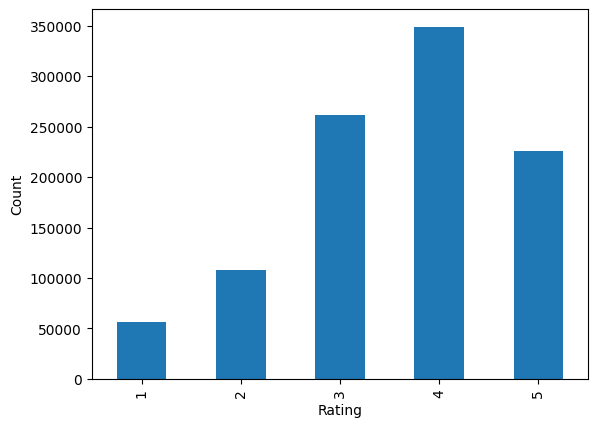

In [26]:
counts = ratings_df["Rating"].value_counts().sort_index()
counts.plot(kind="bar")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

## Part A

**Recommend the top 10 “most popular” movies. The term “most popular” is open
to interpretation from each group. So, it is important to clearly state how you define the
popularity of a movie. The recommendation you make should display the top 10 movie
titles, and information related to the criteria you used - e.g. if you recommend the top 10
movies based on ratings for movies with at least 1,000 ratings, report these numbers.**

We decided to use the given example definition for the top 10 "most popular" movies. Specifically, we define it as the top rated movies with at least 1000 ratings.

In order to do so, we begin by first creating 2 new auxiliary columns to help us with our analysis: `NumRatings` and `AvgRating`. `NumRatings` is number of times that the movie in the `MovieID` column was rated. The `AvgRating` is the average rating of the movie in the `MovieID` column across all of provided ratings.

In [27]:
ratings_by_movie = ratings_df.groupby('MovieID')
ratings_df['NumRatings'] = ratings_by_movie['MovieID'].transform('count')
ratings_df['AvgRating'] = ratings_by_movie['Rating'].transform('mean')

# Sanity checks
assert(ratings_df.drop_duplicates('MovieID')['NumRatings'].sum() == ratings_df.shape[0])
assert(ratings_df["AvgRating"].between(0, 5).all())

Now, we remove any unncessary columns for our analysis and drop any duplicate movies since we have those auxiliary columns already computed

In [28]:
# Drop UserID and Timestamp since we don't need these to determine the most popular movies. Rating can be removed since we will use the AvgRating.
popular_movies = ratings_df.drop(columns=["UserID", "Timestamp", "Rating"])
# We will be filtering using NumRatings at some point. But duplicate movies will have the same "NumRatings" 
# so we need to drop duplicates
popular_movies = popular_movies.drop_duplicates('MovieID')

To satisfy our curiosity and pick a good threshold for the number of ratings, we plot a distributions of the `NumRatings` column

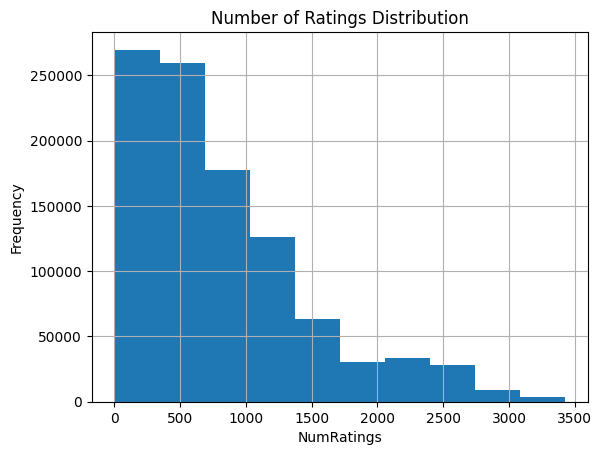

In [29]:
ratings_df["NumRatings"].hist(bins=10)
plt.xlabel("NumRatings")
plt.ylabel("Frequency")
plt.title("Number of Ratings Distribution")
plt.show()

Now, we filter our dataset to only include movies that have been rated at least 1000 times.

In [30]:
# Let's do an initial filter for ratings that at least have 1000 ratings
threshold = 1000
popular_movies = popular_movies[popular_movies['NumRatings'] >= threshold]
popular_movies.shape

(207, 3)

We can now filter for the top 10 movies with the highest average rating

In [31]:
top10 = popular_movies.nlargest(10, "AvgRating")
print(top10.columns)
print(top10)

Index(['MovieID', 'NumRatings', 'AvgRating'], dtype='object')
     MovieID  NumRatings  AvgRating
172      318        2227   4.554558
998      858        2223   4.524966
303       50        1783   4.517106
23       527        2304   4.510417
130     1198        2514   4.477725
932      904        1050   4.476190
44       260        2991   4.453694
903      750        1367   4.449890
505      912        1669   4.412822
38      2762        2459   4.406263


Finally, we get the names corresponding to the resulting MovieID's

In [32]:
# Get back the names of these 10 movies based on the ID

top10 = top10.merge(movies_df[["MovieID", "Title"]], on="MovieID", how="left")
top10

,MovieID,NumRatings,AvgRating,Title
0,318,2227,4.554558,"Shawshank Redemption, The (1994)"
1,858,2223,4.524966,"Godfather, The (1972)"
2,50,1783,4.517106,"Usual Suspects, The (1995)"
3,527,2304,4.510417,Schindler's List (1993)
4,1198,2514,4.477725,Raiders of the Lost Ark (1981)
5,904,1050,4.476190,Rear Window (1954)
6,260,2991,4.453694,Star Wars: Episode IV - A New Hope (1977)
7,750,1367,4.449890,Dr. Strangelove or: How I Learned to Stop Worr...
8,912,1669,4.412822,Casablanca (1942)
9,2762,2459,4.406263,"Sixth Sense, The (1999)"


The above shows the top 10 most "popular" movies where popular is defined as the movies that have the highest average rating out of the movies that were rated at least 1000 times. The above table also reports the associated average rating and number of ratings for each of the movies.

## Part B

**Make a recommendation based on Item-Based Collaborative Filtering (IBCF) by
writing your own IBCF function following the steps below:**

### 1. 

**Create the rating matrix by R, where the rows correspond to users and the columns
to movies. Normalize R by centering each row, i.e. subtract the row means from
each row of the matrix. The matrix is sparse, so the row means should be computed
based on the non-NA entries.**

In [33]:
# Quick check to see if there are any missing values in the Rating column 
ratings_df['Rating'].isna().any()

np.False_

In [34]:
grouped_ratings = ratings_df.groupby('UserID')
# Create a matrix of size Number of Unique Users x Number of Unique Movies filled with NaNs
R = np.full((ratings_df['UserID'].max(), ratings_df['MovieID'].max()), np.nan)

# Go through each row in the original dataframe and fill the rating into our rating matrix
# UserID and MovieID is 1-indexed so we account for that by subtracting 1 to get the appopriate index in the rating matrix
for index, row in ratings_df.iterrows():
    R[int(row['UserID'])-1][int(row['MovieID'])-1] = int(row['Rating'])

print(R)
# Check R matches the expected size based on ranges for UserID and MovieID from README
assert(R.shape == (6040, 3952))

[[ 5. nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [ 3. nan nan ... nan nan nan]]


Center the rating matrix R now.

In [35]:
for row in R:
    row -= np.nanmean(row)

print(R)

[[ 0.81132075         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [-0.57771261         nan         nan ...         nan         nan
          nan]]


In [36]:
R = pd.DataFrame(R)

In [37]:
R.head()

,0,1,2,3,4,5,6,7,8,9,...,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951
0,0.811321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,-1.146465,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2
**Compute the cosine similarity for all the movies. You can ignore similarities computed based on less than 3 user ratings. You can also use the (1 + cos)/2 transformation to ensure than the similarity will be between 0 and 1. Keep in mind that
you may have NAs when a pair off movies (for example) has been rated by 0, 1, or
2 users, or when the denominator in the similarity metric is zero.**

In [38]:
threshold

1000

In [39]:
# Count the number of non-NaN values over the columns
non_null_counts = R.count()

# ZL: I'm guessing threshold was meant to be set to 3? Right now it'll use the threshold of 1000 from before. 
# ZL: I also think it's supposed to be pairwise threshold rather than per column see comment below.

columns_above_threshold = set(non_null_counts[non_null_counts > 3].index.tolist())

# Do they mean just drop all columns with less than 3 reviews?
# ZL: I think it's based on the number of shared ratings between 
# the 2 movies. So if we may have 2 movies A and B where movie A has M ratings from various users and movie B has N users who gave ratings.
# However, those M and N ratings may consist of different subset of users. So there may only be 2 users who actually provided a rating
# for A and B, and so the cosine similarity metric would be considered not reliable in this case. So we set the similarity to NaN in this case?
# Basing this off CW post #422 (https://campuswire.com/c/G7F20F6FC/feed/422)

In [40]:
not_nan = ~np.isnan(R)
R_notnan = np.where(not_nan, R, 0.0)
co_counts = R_notnan.T @ R_notnan
R_filled = np.nan_to_num(R, nan=0.0)

dot_products = R_filled.T @ R_filled

norms = np.linalg.norm(R_filled, axis=0)   

denom = np.outer(norms, norms) 

# avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    sim = (1 + (dot_products / denom))/2
    sim[denom == 0] = np.nan

sim[co_counts < 3] = np.nan
np.fill_diagonal(sim, 1.0)
print(sim)

[[1.                nan        nan ... 0.50559934 0.50990867 0.51875173]
 [       nan 1.         0.51034112 ...        nan        nan        nan]
 [       nan 0.51034112 1.         ...        nan        nan        nan]
 ...
 [0.50559934        nan        nan ... 1.                nan 0.51663784]
 [0.50990867        nan        nan ...        nan 1.         0.54424724]
 [0.51875173        nan        nan ... 0.51663784 0.54424724 1.        ]]


Check to make sure the similarity matrix is symmetric (as it should be).

In [41]:
similarity_matrix_w_zero = np.nan_to_num(sim, nan=0.0)
transpose_matrix = similarity_matrix_w_zero.T
non_symmetric_elements_mask = (similarity_matrix_w_zero != transpose_matrix)
rows, cols = np.where(non_symmetric_elements_mask)
print(rows)
print(cols)
# no discrepancies, making this symmetric

[]
[]


### 3.
**For the similarity matrix in (2), sort the non-NA similarity measures and keep the
top 30, setting the rest to NA. Display the pairwise similarity values for this new
matrix for the following movies:**

• **“Toy Story (1995) (id: 1)”**

• **“GoldenEye (1995) (id: 10)”**

• **“Liar Liar (1997) (id: 1485)”**

• **“Lost World: Jurassic Park (1997) (id: 1544)”**

• **“Sixth Sense, The (1999)” (id: 2762)**

In [42]:
S = sim.copy()
for i in range(S.shape[0]):
    row = S[i].copy()
    row[row==1.0] = np.nan
    top30_sorted_row = np.sort(np.nan_to_num(row, nan=0.0))[-30:]
    filtered_row = np.where(np.isin(row, top30_sorted_row), row, np.nan)
    S[i] = filtered_row
np.fill_diagonal(S, 1.0)

In [43]:
print("Toy Story and GoldenEye: ", S[0][9])
print("Toy Story and Liar Liar: ", S[0][1484])
print("Toy Story and Jurassic Park: ", S[0][1543])
print("Toy Story and Sixth Sense: ", S[0][2761])
print("GoldenEye and Liar Liar: ", S[9][1484])
print("GoldenEye and Jurassic Park: ", S[9][1543])
print("GoldenEye and Sixth Sense: ", S[2761][9])
print("Liar Liar and Jurassic Park: ", S[1484][1543])
print("Liar Liar and Sixth Sense: ", S[1484][9])
print("Jurassic Park and Sixth Sense: ", S[1543][2761])

Toy Story and GoldenEye:  nan
Toy Story and Liar Liar:  nan
Toy Story and Jurassic Park:  nan
Toy Story and Sixth Sense:  0.6257803109680525
GoldenEye and Liar Liar:  nan
GoldenEye and Jurassic Park:  nan
GoldenEye and Sixth Sense:  nan
Liar Liar and Jurassic Park:  nan
Liar Liar and Sixth Sense:  0.5446944158127623
Jurassic Park and Sixth Sense:  nan


### 4.
**Write your own IBCF function:**

• **Input: newuser, i.e. a vector containing ratings for all the movies.
Many of the entries will be NA, while the non-NA values should be ratings 1, 2,
3, 4, 5 - the star ratings.**

• **Output: The top 10 movies recommendation for this new user.
If fewer than 10 predictions are non-NA, select the remaining movies based on
the popularity defined in part (A), prioritizing the most popular ones and excluding those already rated by the user. Here, you may want to save the ranking
of all movies (based on popularity) in a separate file to avoid recomputing the
ranking each time.**

• **The function you write should load the similarity matrix and use it to compute
predictions for movies that have not been rated by the new user yet, using the
formula from the notes/slides.**

In [46]:
def IBCF(newuser, similarity_matrix):
    user_has_rated = ~np.isnan(newuser)
    predictions = np.full(len(newuser), np.nan)
    for i in range(len(newuser)):
        if not user_has_rated[i]:
            curr_movie = similarity_matrix[i, :].copy()
            curr_movie[i] = np.nan
            curr_movie[~user_has_rated] = np.nan
            not_null_indices = np.where(~np.isnan(curr_movie))[0]
            if len(not_null_indices) > 0:
                k = min(10, len(not_null_indices))
                neighbor_indices = not_null_indices[np.argpartition(curr_movie[not_null_indices], -k)[-k:]]
                predictions[i] = np.sum(curr_movie[neighbor_indices] * newuser[neighbor_indices])/(np.sum(np.abs(curr_movie[neighbor_indices])))

    predictions[user_has_rated] = np.nan
    not_null_indices = np.where(~np.isnan(predictions))[0]
    if len(not_null_indices) > 0:
        k = min(10, len(not_null_indices))
        top_k = not_null_indices[np.argsort(predictions[not_null_indices])[-k:]]
        return top_k
    return []

### 5.

**Test your function by displaying the top 10 recommendations for the following two
users:**

• **User in row 1500 from the rating matrix.**

• **A hypothetical user who rates movie “Star Wars: Episode IV - A New Hope
(1977)” with 5 stars and movie “Independence Day (ID4) (1996)” with 4 stars.**

In [50]:
user1500 = R.iloc[1499]
movie_indices = IBCF(user1500.to_numpy(), S)

for movie_idx in movie_indices:
    print(movies_df.iloc[movie_idx]["Title"])

Drugstore Cowboy (1989)
Awakenings (1990)
Central Station (Central do Brasil) (1998)
Repulsion (1965)
Haunted World of Edward D. Wood Jr., The (1995)
Simply Irresistible (1999)
Mad Dog Time (1996)
I Shot a Man in Vegas (1995)
Gossip (2000)
Muppet Movie, The (1979)


In [ ]:
movie_id1 = 260 # Got this from part A final output
rating = 5

movie_id2 = movies_df[movies_df["Title"] == "Independence Day (ID4) (1996)"]["MovieID"].iloc[0]
rating2 = 4

user = np.array([float('nan')] * R.shape[1])
user[movie_id1 - 1] = 5
user[movie_id2 - 1] = 4

movie_indices = IBCF(user, S)

for movie_idx in movie_indices:
    print(movies_df.iloc[movie_idx]["Title"])

[1224 1230 1232 1233 1239 1241 1245 1248 1222 3896]
Manhattan (1979)
Bridge on the River Kwai, The (1957)
Chinatown (1974)
Day the Earth Stood Still, The (1951)
Stand by Me (1986)
Evil Dead II (Dead By Dawn) (1987)
Groundhog Day (1993)
Pump Up the Volume (1990)
Glory (1989)


IndexError: single positional indexer is out-of-bounds